In [1]:
import time
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from quantum.Quantum import QuantumRegressor
from quantum.Circuits import entangling_layers, double_angle, entangle_cnot, mitarai, single_angle, rotation_layer, entangle_cz, composer
from quantum.Evaluate import evaluate_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 

In [2]:
st = time.time()
# Generate random data
np.random.seed(4)  # Set seed for reproducibility
X = np.random.uniform(low=0, high=10, size=(100,))
y = np.sin(X / 2)

# Reshape X to (-1, 1)
X = X.reshape(-1, 1)

# Normalize the dataset between -1 and 1
scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


## Here we define all of the encoders we will use

Listing encoders to be used and compared i this notebook. This list is derived from Suzuki & Katouda DOI 10.1088/2399-6528/abd3d8

In [3]:
encoders = {
    'M': mitarai,
    'A1': single_angle,
    'A2': double_angle,
    'M-M-CNOT': composer(mitarai, entangle_cnot, mitarai, entangle_cnot),
    'A1-A1-CNOT': composer(single_angle, entangle_cnot, single_angle, entangle_cnot),
    'A2-A2-CNOT': composer(double_angle, entangle_cnot, double_angle, entangle_cnot),
    'M-A1-CNOT': composer(mitarai, entangle_cnot, single_angle, entangle_cnot), 
    'M-A2-CNOT': composer(mitarai, entangle_cnot, double_angle, entangle_cnot),
    'M-M-CZ': composer(mitarai, entangle_cz, mitarai, entangle_cz),
    'A1-A1-CZ': composer(single_angle, entangle_cz, single_angle, entangle_cz),
    'A2-A2-CZ': composer(double_angle, entangle_cz, double_angle, entangle_cz),
    'M-A1-CZ': composer(mitarai, entangle_cz, single_angle, entangle_cz),
    'M-A2-CZ': composer(mitarai, entangle_cz, double_angle, entangle_cz)
}


## Model training

Here we define the parameters of our model and a random set of initial parameters. Then we loop through each of the encoders and train the model for them and evaluate/plot it. We also compare through Pure QML models and Hybrid QML models as defined in Suzuki & Katouda

Starting on: M encoder...

Training completed taking  414.4215877056122 seconds

Starting on: M encoder pure QML...

Training completed taking  399.96026611328125 seconds

Starting on: A1 encoder...

Training completed taking  438.2304813861847 seconds

Starting on: A1 encoder pure QML...

Training completed taking  408.35505771636963 seconds

Starting on: A2 encoder...

Training completed taking  480.3066372871399 seconds

Starting on: A2 encoder pure QML...

Training completed taking  438.0940091609955 seconds

Starting on: M-M-CNOT encoder...

Training completed taking  487.90571999549866 seconds

Starting on: M-M-CNOT encoder pure QML...

Training completed taking  421.610951423645 seconds

Starting on: A1-A1-CNOT encoder...

Training completed taking  482.20639181137085 seconds

Starting on: A1-A1-CNOT encoder pure QML...

Training completed taking  445.65688848495483 seconds

Starting on: A2-A2-CNOT encoder...

Training completed taking  537.2683629989624 seconds

Starting on: A2

ValueError: num must be an integer with 1 <= num <= 15, not 16

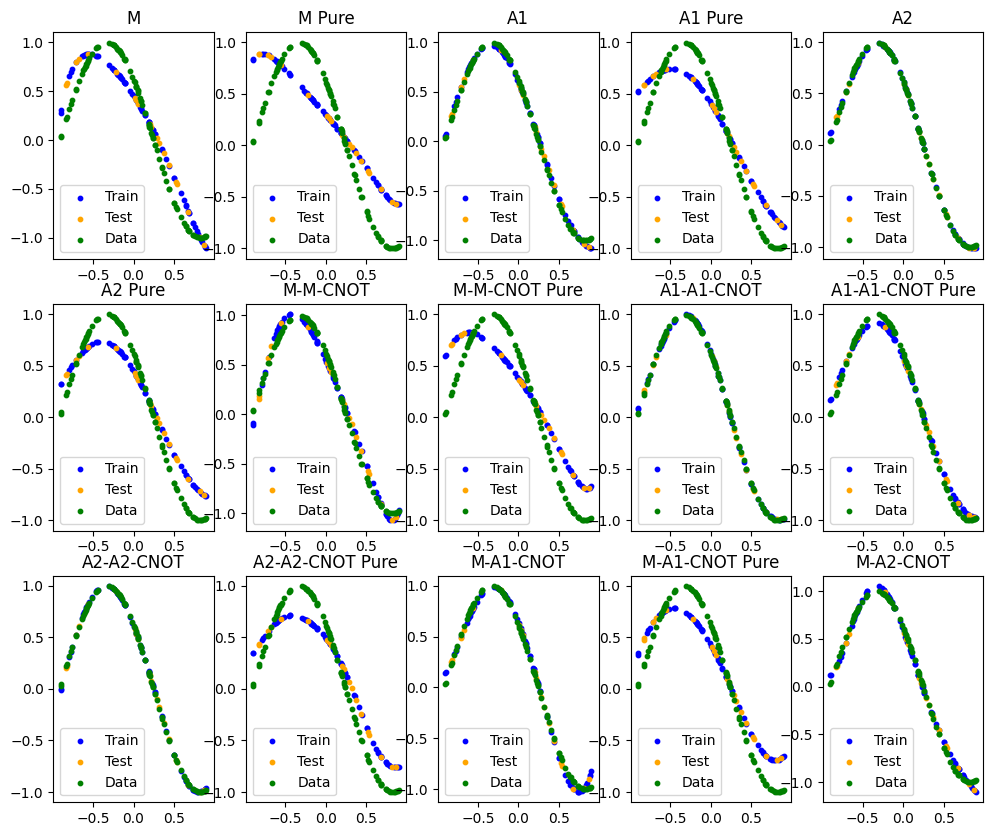

In [4]:
num_qubits = 3
layers = 3
initial_parameters = np.random.uniform(low=-1, high=1, size= 2 * 3 * num_qubits) # 3 params per qubit and 2 layers
extra_parameters = np.random.uniform(low=-1, high=1, size=3)
new_parameters = np.concatenate((initial_parameters, extra_parameters))

variational = entangling_layers # entangling layers infers number of layers from number of parameters

results = {}

fig = plt.figure(figsize=(12, 2*5), dpi=100)
n_cols = 5
n_rows = (int(len(list(encoders.keys())) / n_cols) + 1 ) * 2
i=0

for name, encoder in encoders.items():
    print('Starting on:', name, 'encoder...\n')
    st = time.time()
    model = QuantumRegressor(encoder, variational, num_qubits, pure_qml=False)
    opt_results = model.fit(X_train, y_train, new_parameters, detailed_results=True)
    et = time.time()
    print('Training completed taking ', et-st, 'seconds\n')
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    loss = evaluate_model(model, X_train, X_test, y_train, y_test, title=name)
    i += 1
    results[name] = [opt_results, loss]
    
    
    print('Starting on:', name, 'encoder pure QML...\n')
    st = time.time()
    model = QuantumRegressor(encoder, variational, num_qubits, pure_qml=True)
    opt_results = model.fit(X_train, y_train, initial_parameters, detailed_results=True)
    et = time.time()
    print('Training completed taking ', et-st, 'seconds\n')
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    loss = evaluate_model(model, X_train, X_test, y_train, y_test, title=name+' Pure')
    i += 1
    results[name+" pure"] = [opt_results, loss]
plt.tight_layout()

In [ ]:
for name, result in results.items():
    print('Name: ' + name)
    print('Opt result:', result[0])
    print('Loss functions:', result[1], '\n')